# Attack Estimation : Bayesian Networks


# Overview

This notebook will introduce you to Bayesian Networks and how to perform inference on them using Bucket Elimination.

After a motivation of why Bayesian Networks are important and what they can be used for, we will introduce you to the task you were given: Defending your galactic empire using Bayesian Networks.

After covering some necessary math background, we will go over the key insight of the algorithm. Then we will explain the algorithm in three ways: First with intuition, then with pseudocode and lastly with formal mathematics. 

This will be followed by an explanation of how to use our code and some examples will follow. 
The main learning outcome is to 
* understand Bayesian Networks and Bucket Elimination
* be able to run the Bucket Elimination algorithm
* have the resources to implement the algorithm at a later date

## Motivation

Why are Bayesian Networks and why should we be interested in them?

Bayesian probability estimates are a powerful tool for inferring a probability distribution for a hidden state based on observations.  However, for large state spaces with many random variables, each of which may depend on some subset of the other variables, we would like to impose some kind of structure on the probabilistic model that makes the conditional independence relations between variables obvious. The Bayesian Network is a network structure that does exactly this.  

For example you can impose a complicated structure like below, where the presence of rain affects grass growth, the mood of the cat and whether umbrellas are used. The presence of rain is itself affected by atmospheric pressure and the season. Conditional probability tables capture the  probabilities of the children nodes (e.g. rain) taking certain values conditioned on the values of their parent nodes (season and atmospheric pressure). 

Given such a graph of relationships, conditional probabilities and the observed values of some nodes, the aim of this notebook is to infer the states of other nodes.  

![](https://drive.google.com/uc?export=view&id=1HrJKzxjcjlig-yTGmNut5DtXl3Q_UXfI)

## Problem: Attack Estimation

We will be concentrating on the specific example of attack estimation. 

Imagine the following scenario. You are the chief scientist of the Generic Space Empire under attack by rebels.

![](https://drive.google.com/uc?export=view&id=1viiwvQpyBrxAfeLBOm8SSWQ3M5zM30A0)

The Underdog Rebel attackers can perform various attacks, which will damage subsystems of the Generic Space Empire's space station, each of which may contain one or more precious workstations.  The engineers on the space station can use diagnosis droids to observe which workstations are damaged.  Given a set of observations, we wish to infer the probability distribution over what attacks took place.  

There are two specific objects that we want to compute:
* Maximum A Posteriori (MAP) Hypothesis: Determine the most likely configuration of attack variables given the value of the observations and summing (marginalizing) over other nuissance nodes. 
* Posterior Distribution over attacks (belief updating): Determine the posterior distribution for a single node given observations in other nodes marginalized over the value of other nodes.

In order to rise to the task of saving your galactic empire, you first have to read up on Bayesian Networks. 


![](https://drive.google.com/uc?export=view&id=1hszXxSLcK1R2rwBYH75XPbDmiT0meKoX)

Let's first look at what our algorithm is supposed to achieve from a black box perspective. After gaining this high level understanding, we will look into how the bucket elimination algorithm can solve this problem. 


To see the application of Bayesian Networks, let's import our implementation of a BayesNet and helper classes. You can either [load the local file](https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab/48919022) bayesnet.py. Otherwise you can add the file to your google drive and mount the drive using the following cell. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from bayesnet import *

Let's first generate an example problem. Here we have three attack nodes that have binary values, that effect some subsystems. These in turn then affect some worker nodes. Exactly how this problem is generated will be explained in the implementation section.

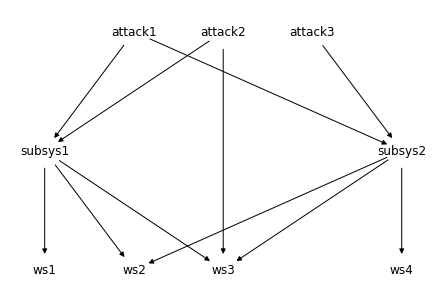

In [2]:
example_nodes, pos = generate_problem()

model = BayesNet("Attack Estimation on Example Network")
model.add_nodes(example_nodes)
model.infer_edges()
model.plot_graph(pos=pos)

Given this structure, let's note the observations and decide a list of nodes over which we want to compute a Maximum A Posteriori Estimation. An observation is an assignment of a value to any node. Note, that while the most likely configuration will be computed for all interest nodes, the posterior will only be estimated on the first node in the list of interest nodes.


In [3]:
observations = {"ws1": 1, "ws2": 0, "ws3": 0, "ws4": 1}
interest_nodes = ["attack1", "attack2", "attack3"]
ordering = ["attack1", "attack2", "attack3", "subsys1", "subsys2", "ws1", "ws2", "ws3", "ws4"]

res_BEL, res_MAP = model.bucket_elim(observations, interest_nodes, ordering, DEBUG=False)
print("Most likely configuration:", res_MAP)
print("Posterior distribution for node {}: P(0)={}, P(1) = {} ".format(interest_nodes[0], res_BEL[interest_nodes[0]][0], res_BEL[interest_nodes[0]][1] ))

Running bucket_backward
Running bucket_forward
Most likely configuration: {'attack1': 0, 'attack2': 1, 'attack3': 0}
Posterior distribution for node attack1: P(0)=0.7805236114509421, P(1) = 0.21947638854905804 


Here you can see that the probability that attack1 happened is 22%. However, it looks like the rebels are performing attack2. This is where we should strength our defenses next time. If we could run this algorithm on different problems, we would know what the rebels are up to every time.

Now we know our goal: To use bucket elimination to compute MAP hypothesis and posterior distributions given observations. 

While we will come back to implementation details in the implementation section, the next section will give us the necessary math background to understand bucket elimination.

## Math Background

Let's brush up on some necessary mathematics.

Let us represent our sample space using discrete random variables $X_i$, which have domains $D_i = \{x_1, \dots, x_m\}$ and probability distributions $\Pr(X_i) : D_i \rightarrow [0, 1]$.

If two random variables $A$ and $B$ are independent (denoted $A \perp B$), we have:
$$
\Pr(A | B) = \Pr(A)
$$
and, as a result,
$$
\Pr(A, B) = \Pr(A | B) \Pr(B) = \Pr(A) \Pr(B)
$$
If random variables $A$ and $B$ are independent conditional on $C$:
$$
\Pr(A | B, C) = \Pr(A | C)
$$

Since all our random variables are discrete, we can express the relation $\Pr(A | B)$ using a conditional probability table (CPT) that gives the probability of each possible value of $A$ given a value of $B$.  

The three main actions we want to perform on probability distributions are:
* Joining (also known as Factoring or Combining): given $X_1 \perp X_2$,
$$
\Pr(X_1, X_2) = \Pr(X_1) \Pr(X_2)
$$
* Conditioning:
$$
\Pr(X_2, X_3 | X_1 = x_1) = \frac{\Pr(x_1, X_2, X_3)}{\sum_{x_2, x_3} \Pr(x_1, x_2, x_3)}
$$
* Marginalization:
$$
\Pr(X_2, X_3) = \sum_{x_1} \Pr(x_1, X_2, X_3)
$$

A Bayesian network is a directed acyclic graph: a graph where edges have associated directions (thus connecting ordered pairs of nodes) and there are no cycles (in other words, from any node, there is no way to reach that node again by traversing edges).  The nodes $X_i$ are random variables, the edges $X_i \rightarrow X_j$ denote the dependence of $X_j$ on its parent $X_i$, and each node $X$ is associated with a CPT describing $\Pr(X | Parents(X))$.  Each node in a Bayes net must be conditionally independent, conditioned on its parents, of all other nodes in the network that are not descended from it; a node is always dependent on its parents and children.  Due to this structure, we can use edges $X_i \rightarrow X_j$ to model causal relationships.  

## Bucket Elimination: Key Insight

Bucket elimination is a method that can be used for probabilistic-inference tasks like belief updating and finding the MAP hypothesis on a Bayes net.  Its inputs are the network, which contains conditional probability tables, a set of variable observations and an ordering of variables. In this section we will understand the main insight behind Bucket Elimination by considering the specific example graph below. 

Imagine you want to compute the posterior for A, given that you have observed that the value of the node G is g=1. In theory we could compute the joint probability $\Pr(g, f, d, c, b, a)$ for g=1 and all other values of the other variables. We could then sort all of these probabilities and sum them up for the different values of A as follows:

\begin{align*}
\Pr(a, g = 1) &= \sum_{c, b, f, d, g=1}\Pr(g, f, d, c, b, a) \\
&= \sum_{c, b, f, d, g=1}\Pr(g | f) \Pr(f | b, c) \Pr(d | a, b) \Pr(c | a) \Pr(b | a) \Pr(a) 
\end{align*}

To get an estimate for A's posterior, we could multiply each value of A by its prior and to get a MAP estimate, we would just have to take the maximum value. While this is a valid algorithm, it quickly become prohibitively expensive, as it is exponential in the domains of th variables. We need an algorithm that inteligently uses the structure of the Bayesian Network to get better scaling.

![](https://drive.google.com/uc?export=view&id=1sREZcYm8puz11r7nYx5GChmllTlq23AP)

The main insight of the Bucket Elimination algorithm is that the sums don't have to be performed at the end. As each term in the product depends only on some variables, these partial sums can be computed first, yielding significant speed gains. 

The above network for example imposes a structure $\Pr(g, f, d, c, b, a) = \Pr(g | f) \Pr(f | c, b) \Pr(d | b, a) \Pr(b | a) \Pr(c | a) \Pr(a)$. Hence, the sum can be broken up as follows:

\begin{align*}
\Pr(a, g = 1) &= \sum_{c, b, f, d, g=1}\Pr(g | f) \Pr(f | b, c) \Pr(d | a, b) \Pr(c | a) \Pr(b | a) \Pr(a) \\
&= \Pr(a) \sum_c \Pr(c | a) \sum_b \Pr(b | a) \sum_f \Pr(f | b, c) \sum_d \Pr(d | b, a) \sum_{g=1} \Pr(g | f)
\end{align*}



These sums can then be computed mechanically from right to left. Each summation produces a function in the variables that were not eliminated by the sum, which we denote by $\lambda$ (for example, $\lambda_G(f) = \sum_{g=1} \Pr(g | f)$):
\begin{align*}
&= \Pr(a) \sum_c \Pr(c | a) \sum_b \Pr(b | a) \sum_f \Pr(f | b, c) \lambda_G(f) \sum_d \Pr(d | b, a) \\
&= \Pr(a) \sum_c \Pr(c | a) \sum_b \Pr(b | a) \lambda_D(a, b) \sum_f \Pr(f | b, c) \lambda_G(f) \\
&= \Pr(a) \sum_c \Pr(c | a) \sum_b \Pr(b | a) \lambda_D(a, b) \lambda_F(b, c) \\
&= \Pr(a) \sum_c \Pr(c | a) \lambda_B(a, c) \\
&= \Pr(a) \lambda_C(a)
\end{align*}


The answer to the query $\Pr(a | g=1)$ can then be given by normalizing the last product. 

## Bucket Elimination: Intuition

Bucket Elimination takes this insight of how to simplify the sums and implements MAP and posterior estimation in code. It does so by keeping track of the levels of the summation using so-called buckets, where each bucket correspons to summation over a single node.  

The algorithm iterates over the buckets twice for MAP estimates and once for Posterior estimates: 

* Backward Pass (for MAP and Posterior): Given an ordering (here $A, C, B, F, D, G$), it iteratively computes the $\lambda$ functions in the reverse direction. Once only one variable remains, we can read off the posterior estimates. 
* Forward Pass (for MAP only): To estimate the maximum configuration, the maximum value of the posterior for the variable first in the order is chosen. This is then propagated to the second variable and so on until we have the most likely configuration of the variables of interest. 

In the forward pass each bucket is treated differently, depending on what we want to do for this variable:
* Assignment (Observation): If we have observed a value for this variable, we simply assign it. 
* Summation (Marginalization): If we have not observed the value and this is not a parameter of interest, we marginalize/sum over all of its possible values. Note that this procedure happens to all unobserved nodes that are not of interest. We can also call these nodes nuissance nodes. Notice that for the Posterior Estimation all but the last node and observation nodes are nuissance nodes.
* Maximization (MAP): When we are running the MAP algorithm, all nodes of interest will run in Maximization mode. Here, sums are replaced by maximization to produce the $\lambda$ functions, but otherwise everything remains the same.




The buckets for bucket elimination are sorted acording to the particular variable ordering and then filled. Each conditional probability table (CPT), and observation is put into the bucket corresponding to the variable of lowest order that it contains. For our example problem the buckets are initialized as shown on the left below. Intermediate $\lambda$ functions are computed as shown on the right below. In the forward pass, the resulting $\lambda$ functions are passed to the bucket corresponding to the next highest variable that is an argument of the $\lambda$ function.



 

![](https://drive.google.com/uc?export=view&id=13JViFl_rVEsZBEomDs2UAINrXK-kHQ6P)

To process $bucket_G$ in our specific example, we sum over all values of $g$ to marginalize out $g$ -- in this case, we have observed $g = 1$, so this summation is over a single value.  This computes the function $\lambda_G(f) = \sum_{g=1} \Pr(g | f)$, which is placed in $bucket_F$.  Similarly, processing $bucket_D$ yields $\lambda_D(b, a) = \sum_d \Pr(d | b, a)$, which is placed in $bucket_B$.  This continues until we reach bucket $A$ and can compute $\Pr(a | g=1) = \alpha \Pr(a) \lambda_C(a)$.  

## Bucket Elimination: Pseudocode

This section gives a succinct pseudocode explanation of Bucket Elimination. This is especially useful if you wish to implement the algorithm yourself. The algorithm complexity in time and space is dominated by a term quadratic in the domain sizes. 

Given that $BN$ is a Bayes net, $A$ is a subset of the variables in the Bayes net, $d$ is an ordering of variables in which the variables in $A$ are first, and $e$ is a set of observations, we can find the maximum aposteriori hypothesis (MAP) assignment to the variables in $A$ using the following pseudocode for bucket elimination:

* Assign to $bucket_i$ all CPTs whose highest value is $X_i$ and any observations of variable $X_i$
* Let $S_1 \dots S_j$ be the subset of variables in a bucket on which CPTs are defined.
* Backward pass: for $p = n$ down to 1,
  * for all the CPTs $h_1, h_2, \dots, h_j \in bucket_p$,
    * if $bucket_p$ contains the observation $X_p = x_p$, assign $X_p = x_p$ to each $h_i$ and put the resulting CPTs in lower buckets as appropriate
    * otherwise:
      * if $X_p$ is not in A and $bucket_p$ contains new CPTs, marginalize out $X_p$:
        * let $h_p = \sum_{X_p}{\prod_{i=1}^{j} h_i}$
        * let $U_p = \bigcup_{i=1}^{j}{S_i}  - $ \{ $X_p$ \} 
      * otherwise $(X_p \in A)$, maximize over $X_p$:
        * let $h_p = \max_{X_p}\prod_{i=1}^{j}{h_i}$ 
        * let $a^0_p = \arg \max_{X_p}{h_p}$
      * Then add $h_p$ to the bucket of the largest-index variable in $U_p$. 
* Forward pass: Assign values in the ordering $d = A_1,\dots,A_k$, using the information recorded in each bucket.

Bucket elimination can operate in two modes during the backward pass: marginalization mode or maximization mode.  To compute the MAP, we first marginalize out all the variables that aren't in $A$, then maximize over the variables in $A$.  To compute the posterior distribution over a single variable, we proceed in marginalization mode until only the variable of interest remains (and we need to ensure that this variable is first in the ordering), then return the final distribution instead of maximizing over the single remaining variable.  

## Bucket Elimination: Formal

A formal version of the bucket elimination procedure follows below for completeness. If you are only interested in its practical application you can safely skip this section. Remember, we have some rebels to defeat. 

Consider an ordering of the variables $X = (X_1, \dots, X_n)$, where we want $\Pr(x_1 | e)$.  Let $\bar{x}_i = (x_1, \dots, x_i)$, $\bar{x}_i^j = (x_i, x_{i+1}, \dots, x_j)$, $F_i$ be the family of variable $X_i$ ($X_i$ and its parent variables), $pa_i$ be the parents of $X_i$, and $ch_i$ be the children of $X_i$.  We want:
$$
\Pr(x_1, e) = \sum_{x = \bar{x}_2^n} \Pr(\bar{x}_n, e) = \sum_{\bar{x}_2^{(n-1)}}\sum_{x_n} \prod_i \Pr(x_i, e | x_{pa_i})
$$
Separating $X_n$ from the other variables yields:
\begin{align*}
&\sum_{x = \bar{x}_2^n} \prod_{X_i \in X - F_n} \Pr(x_i, e | x_{pa_i}) \sum_{x_n} \Pr(x_n, e | x_{pa_n}) \prod_{X_i \in ch_n} \Pr(x_i, e | x_{pa_i}) \\
&= \sum_{x = \bar{x}_2^n} \prod_{X_i \in X - F_n} \Pr(x_i, e | x_{pa_i}) \lambda_n(x_{U_n})
\end{align*}
where
$$
\lambda_n(x_{U_n}) = \sum_{x_n} \Pr(x_n, e | x_{pa_n}) \prod_{X_i \in ch_n} \Pr(x_i, e | x_{pa_i})
$$
and $U_n$ are the variables that appear with $X_n$ in a probability component, including $X_n$ itself.  This continues recursively with $X_{n-1}$.  

To process each bucket, all the bucket's functions $\lambda_1 \dots \lambda_j$ are multiplied, and the bucket's variable is eliminated by summation, producing
\begin{align*}
\lambda_p &: U_p \rightarrow R \\
\lambda_p &= \sum_{X_p} \prod_{i=1}^j \lambda_i
\end{align*}
where $U_p = \bigcup_i S_i - \{X_p\}$ (and $S_i$ is the subset of variables that $\lambda_i$ is defined over).  This function $\lambda_p$ is placed in the bucket of the largest-index variable in $U_p$.  Once all the buckets have been processed from last to first, the answer to the query is present in the first bucket.  




## Description of implementation


In this section we give a short explanation of how we have implemented Bucket Elimination, so you can follow along with the examples in the next section and construct your own. 

The three classes we use to define the network architecture and conditional probability tables are `Distrib`, `Node`, and `BayesNet`.  

`Distrib` is used to store probability distributions.  A prior distribution for a node of name "node_name" that has no parents can be defined as:
```python
Distrib([1/5, 4/5], vars=["node_name"])
```
Here we have chosen to have a distribution over only two values with probabilities 1/5 and 4/5, respectively. However, you can implement any distribution of a finite number of elements. For simplicity the different values of the variables are not named, but are just refered to by their index. You can use the method Distrib.check_sum1() to see if this is a proper normalized distribution. 



A conditional distribution for a node with parents can be defined as follows:
```python
Distrib([[[0.9,0.4], [0.5,0.3]], [[0.1,0.6], [0.5,0.7]]], vars=["node_name", "parent1", "parent2"])
```
Here the input is assumed to be a 3D matrix in list form, where the indices follow the ordering of the vars (e.g. matrix[1][0][2] has node_name's 1st element, parent1's 0th element and parent2's 2nd element).




`Node` is used to store the conditional probability table and connectivity information for a single node in the network.  For example:
```python
Node(distrib, parents=[parent1, parent2], name="node_name")
```
where `distrib` is a `Distrib` describing the conditional probability distribution for variables `["node_name", "parent1", "parent2"]` and `parents` is a list of other `Node`s.  

`BayesNet` is the central class that actually performs inference tasks.  It takes as input just its name. `Node` objects have to be added by using `BayesNet.add_nodes()` and then `BayesNet.infer_edges()` run. After the positions of the graph are provided as a dictionary, the graph can be plotted using `BayesNet.plot_graph(pos)`. 

Bucket elimination can be run using `BayesNet.bucket_elim(observations, interest_nodes, ordering)`, where interest_names and ordering are a list of node name strings, and observations is a dictionary of node name strings as keys and their observed values as values. 


## Return to the Attack Estimation Example

Now that you understand Bucket Elimination and the classes that our code uses, you are ready to face the invasion of the Underdog Rebel attackers. 

Remember the scenario. You are the chief scientist of the Generic Space Empire under attack by rebels.

![](https://drive.google.com/uc?export=view&id=1U3dNHUGQttYGdE_yN-1ZjfaNsI1ltnrm)

The Underdog Rebel attackers can perform various attacks, which will damage subsystems of the Generic Space Empire's space station, each of which may contain one or more precious workstations.  The engineers on the space station can use diagnosis droids to observe which workstations are damaged.  Given a set of observations, we wish to infer the probability distribution over what attacks took place.  

Let us construct the example in full. If you ever face any Bayesian Network graph in the future, you can easily adapt this problem so it suits your needs. But seriously, what could be cooler than fending off Underdog Rebels? 

In our example, all of our random variables happen to be binary (but our code supports any discrete support): either an attack happened or it didn't, and a subsystem or workstation can be either working or not working.  

We have three attacks, which we will give arbitrary priors.

In [50]:
attack1 = Node(Distrib([4./5, 1./5], vars=["attack1"]), name="attack1")
attack2 = Node(Distrib([2./3, 1./3], vars=["attack2"]), name="attack2")
attack3 = Node(Distrib([3./4, 1./4], vars=["attack3"]), name="attack3")

Next, we create the nodes corresponding to subsystems 1 and 2.  The variable corresponding to subsystem 1's intactness state is causally dependent on attacks 1 and 2; likewise, the subsystem 2 node is causally dependent on attacks 1 and 3.  

In [55]:
subsys1_d = Distrib([[[0.1,0.99], [0.5,0.3]], [[0.9,0.01], [0.5,0.7]]],
                    vars=["subsys1", "attack1", "attack2"])
subsys1_d.check_sum1()
subsys1 = Node(subsys1_d, parents=[attack1, attack2], name="subsys1")

subsys2_d = Distrib([[[0.7,0.5], [0.1,0.8]], [[0.3,0.5], [0.9,0.2]]],
                    vars=["subsys1", "attack1", "attack3"])
subsys2_d.check_sum1()
subsys2 = Node(subsys2_d, parents=[attack1, attack3], name="subsys2")

Finally we create the nodes corresponding to the four workstations.

In [56]:
ws1_d = Distrib([[0.999], [0.001]], vars=["ws1", "subsys1"])
ws1_d.check_sum1()
ws1 = Node(ws1_d, parents=[subsys1], name="ws1")

ws2_d = Distrib([[[0.9,0.8], [0.5,0.3]], [[0.1,0.2], [0.5,0.7]]],
                vars=["ws2", "subsys1", "subsys2"])
ws2_d.check_sum1()
ws2 = Node(ws2_d, parents=[subsys1, subsys2], name="ws2")

ws3_d = Distrib([[[[0.1,0.99], [0.5,0.3]], [[0.7,0.5], [0.1,0.2]]],
                 [[[0.9,0.01], [0.5,0.7]], [[0.3,0.5], [0.9,0.8]]]],
                vars=["ws3", "subsys1", "attack2", "subsys2"])
ws3_d.check_sum1()
ws3 = Node(ws3_d, parents=[subsys1, attack2, subsys2], name="ws3")

ws4_d = Distrib([[0.3], [0.7]], vars=["ws4", "subsys2"])
ws4_d.check_sum1()
ws4 = Node(ws4_d, parents=[subsys2], name="ws4")

Now that all of our nodes have been created, we can assemble the graph.

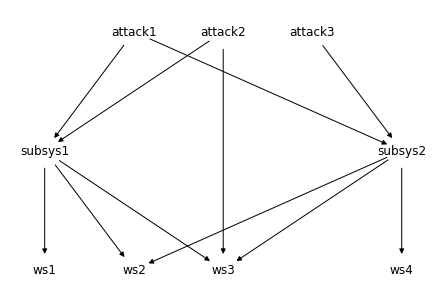

In [57]:
model = BayesNet("Attack Estimation on Example Network")
model.add_nodes([attack1, attack2, attack3, subsys1, subsys2, ws1, ws2, ws3, ws4])

# Plot the network
pos = {"attack1": [-1, 1], "attack2": [0, 1], "attack3": [1, 1],
       "subsys1": [-2, 0], "subsys2": [2, 0],
       "ws1": [-2, -1], "ws2": [-1, -1], "ws3": [0, -1], "ws4": [2, -1]}
model.infer_edges()
model.plot_graph(pos=pos)

Note that this is exactly the problem we had outlined at the start of this notebook. This time, you understand what we have done and what our algorithm does. Let's run it. 

From this graph and the given conditional distributions, as well as a set of observations, we can determine the posterior distribution and the most likely configuration of variables of interest:

In [5]:
observations = {"ws1": 1, "ws2": 0, "ws3": 0, "ws4": 1}
interest_nodes = ["attack1", "attack2", "attack3"]
ordering = ["attack1", "attack2", "attack3", "subsys1", "subsys2", "ws1", "ws2", "ws3", "ws4"]

res_BEL, res_MAP = model.bucket_elim(observations, interest_nodes, ordering)
print("Most likely configuration:", res_MAP)
print("Posterior distribution for node {}: P(0)={}, P(1) = {} ".format(interest_nodes[0], res_BEL[interest_nodes[0]][0], res_BEL[interest_nodes[0]][1] ))

Running bucket_backward
Running bucket_forward
Most likely configuration: {'attack1': 0, 'attack2': 1, 'attack3': 0}
Posterior distribution for node attack1: P(0)=0.7805236114509421, P(1) = 0.21947638854905804 


Great job, you did it. Long live the empire! You have the best estimate of where exactly the Rebels attacked (attack2). You have proven yourself to be a great chief scientist and shall hopefully not be crushed by the empire. 

If you want, you can read a little about about how bucket ordering can effect your performance... Or you can sit back, relax and bask in the glory of the empire. 




![](https://drive.google.com/uc?export=view&id=1oPtbQnDQkTka-Y7cau6VehACsBxoKPUy)

## Optional: Variable Ordering


This is an optional discussion of variable ordering in Bucket Elimination. 

Variable ordering in an input into the Bucket Elimination algorithm that can affect practical performance significantly and is non-trivial. In fact, the complexity of Posterior estimation is (time and space)exponential in the induced width w(d) of the network's ordered moral graph.

There are a few principled ways of tackling this issue, but they are beyond the scope of the notebook. Note, however, that the nodes of interest should come first in the ordering.

Consider again our example from the earlier section. If we use a variable ordering consistent with the topological structure of the graph (if $B$ descends from $A$, $B$ comes after $A$ in the variable ordering, for all variables $A$ and $B$), we can skip some buckets that will degenerate to the constant 1.  We skip buckets if, during processing, the bucket contains no evidence variable and no newly computed function.  This is because a topological ordering will initially give to each bucket at most one function $\Pr(X | pa(X))$, and without any evidence or new functions, summing over this function for all values of $x$ yields 1.  




![](https://drive.google.com/uc?export=view&id=1sREZcYm8puz11r7nYx5GChmllTlq23AP)

For our original ordering $A, C, B, F, D, G$ the bucket initialization looks like this:
\begin{align*}
bucket_G &= \Pr(g | f), g = 1 \\
bucket_D &= \Pr(d | b, a) \\
bucket_F &= \Pr(f | b, c) \\
bucket_B &= \Pr(b | a) \\
bucket_C &= \Pr(c | a) \\
bucket_A &= \Pr(a) \\
\end{align*}

If we use an ordering of $A, F, D, C, B, G$, however, we get the following buckets:
\begin{align*}
bucket_G &= \Pr(g | f), g = 1 \\
bucket_B &= \Pr(f | b, c), \Pr(d | a, b), \Pr(b | a) \\
bucket_C &= \Pr(c | a), \lambda_B(f, c, a, d) \\
bucket_D &= \lambda_C(a, f, d) \\
bucket_F &= \lambda_D(a, f), \lambda_G(f) \\
bucket_A &= \Pr(a) \lambda_F(a) \\
\end{align*}